### environment set

In [2]:
import os
os.system('source /Users/sologaes/project/hyper/lalsuite/_inst/etc/lalsimulation-user-env.sh')
import time
import inspect, copy
import numpy as np
from astropy import units as u
from astropy.constants import G, c, M_sun, R_sun, L_sun, au, pc
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],
            'axes.unicode_minus': False
         }
rcParams.update(config)

In [4]:
!source /Users/sologaes/project/hyper/lalsuite/_inst/etc/lalsimulation-user-env.sh
import lal, lalsimulation
import pycwb
import pycbc
import pycbc.scheme as _scheme
from pycbc import pnutils
from pycbc.types import TimeSeries, FrequencySeries, zeros, Array
from pycbc.types import real_same_precision_as, complex_same_precision_as
from pycbc.fft import fft
from pycbc.filter import interpolate_complex_frequency, resample_to_delta_t

from pycbc.waveform import parameters
from pycbc.waveform import get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import utils as wfutils

/var/folders/0k/8k0xvpzs4tn3l4vh7h5bkplr0000gn/T/ipykernel_48667/910669128.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal, lalsimulation
/Users/sologaes/anaconda3/envs/pycwb/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Welcome to JupyROOT 6.26/10
Loading wavelet library
Trying to load wavelet library from /Users/sologaes/anaconda3/envs/pycwb/lib/python3.10/site-packages/lib/wavelet.so


* test environment for lalsimulation

In [6]:
approximants = td_approximants()
def check_hyperbolic():   
    if "HyperbolicTD" in approximants:
        print("true")

check_hyperbolic()

true


In [78]:
#approximants1 = fd_approximants()
#approximants1

In [48]:
1e-10*lal.PC_SI, 1e-10*pc, 30*G*20*M_sun/c**2, 100*G*20*M_sun/c**2, 20*lal.MSUN_SI*lal.G_SI/lal.C_SI**2,

(3085677.5814913674,
 <Quantity 3085677.58149137 m>,
 <Quantity 885975.02283007 m>,
 <Quantity 2953250.07610025 m>,
 29532.50076100249)

In [84]:
#help(lalsimulation.SimInspiralChooseTDWaveform)


In [82]:
#help(lalsimulation.SimInspiralChooseFDWaveform)
#help(lalsimulation.SimInspiralFD)

### waveform generator

In [326]:
'''hp_f, hc_f = lalsimulation.SimInspiralFD(
        m1=10*lal.MSUN_SI, m2=10*lal.MSUN_SI,
        S1x=0, S1y=0, S1z=0,
        S2x=0, S2y=0, S2z=0,
        distance=1.6e6*lal.PC_SI, inclination=np.pi/3,
        phiRef=0, longAscNodes=0, eccentricity=0, meanPerAno=0,
        deltaF=1./32, f_min=20, f_max=2046, f_ref=20,
        LALparams=params,
        approximant=approximant)'''



'hp_f, hc_f = lalsimulation.SimInspiralFD(\n        m1=10*lal.MSUN_SI, m2=10*lal.MSUN_SI,\n        S1x=0, S1y=0, S1z=0,\n        S2x=0, S2y=0, S2z=0,\n        distance=1.6e6*lal.PC_SI, inclination=np.pi/3,\n        phiRef=0, longAscNodes=0, eccentricity=0, meanPerAno=0,\n        deltaF=1./32, f_min=20, f_max=2046, f_ref=20,\n        LALparams=params,\n        approximant=approximant)'

In [8]:
b_SI = 20*lal.MSUN_SI*lal.G_SI/lal.C_SI**2
params=lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertHyperbolicEccentricity(params, 1.1)
lalsimulation.SimInspiralWaveformParamsInsertImpactParameter(params, 100*b_SI)
approximant = lalsimulation.GetApproximantFromString("HyperbolicTD")

In [10]:
hp_t, hc_t = lalsimulation.SimInspiralChooseTDWaveform(
        m1=10*lal.MSUN_SI, m2=10*lal.MSUN_SI,
        s1x=0, s1y=0, s1z=0,
        s2x=0, s2y=0, s2z=0,
        distance=1.6e6*lal.PC_SI, inclination=np.pi/3,
        phiRef=0, longAscNodes=0, eccentricity=0, meanPerAno=0,
        deltaT=1./4096, f_min=20, f_ref=20,
        params=params,
        approximant=approximant)

### raw data

without any filter

In [18]:
#print("hp:", hp_t.data.data[:10])
amplitude = hp_t.data.data
t_reference = lal.GPSTimeNow()
t_coordinate = np.arange(len(amplitude)) * hp_t.deltaT + hp_t.epoch
t_gps = t_reference + t_coordinate

hp_ts = TimeSeries(hp_t.data.data, delta_t=hp_t.deltaT, epoch=hp_t.epoch)
hc_ts = TimeSeries(hc_t.data.data, delta_t=hc_t.deltaT, epoch=hc_t.epoch)

hp_f = FrequencySeries(np.zeros(len(hp_ts)//2 + 1, dtype=np.complex128), delta_f=1.0/hp_ts.duration)
hc_f = FrequencySeries(np.zeros(len(hc_ts)//2 + 1, dtype=np.complex128), delta_f=1.0/hc_ts.duration)
fft(hp_ts, hp_f)
fft(hc_ts, hc_f)
#print(len(hp_f),len(hp_ts), hp_ts.duration/hp_t.deltaT, hp_f.delta_f)

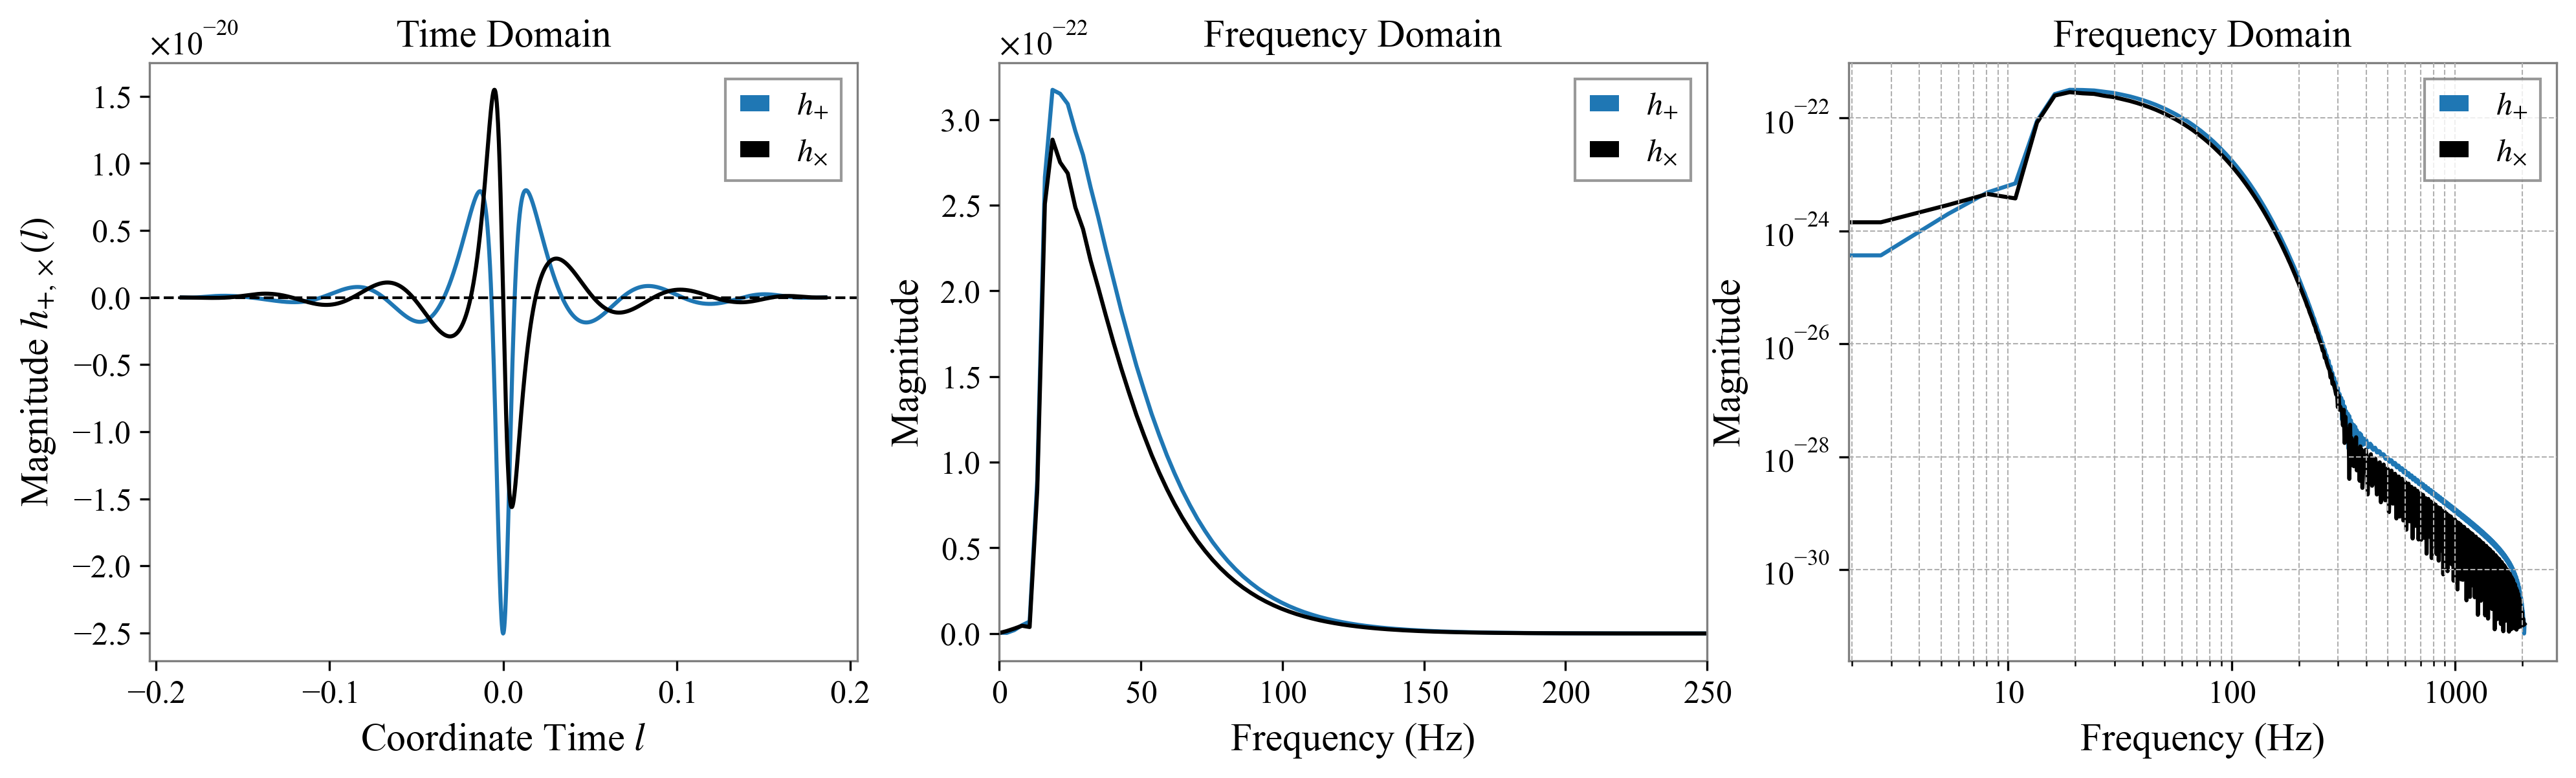

In [19]:
plt.figure(figsize=(16, 4), dpi =300)

plt.subplot(1, 3, 1)
plt.plot(t_coordinate, amplitude, label=r"$h_{+}$")
plt.plot(hc_ts.sample_times, hc_ts, color = "black", label=r"$h_{\times}$")
plt.xlabel(r"Coordinate Time $l$")
plt.ylabel(r"Magnitude $h_{+,\times}(l)$")
plt.axhline(0, color='black', linestyle='--', linewidth=1.0)
plt.title("Time Domain")
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hp_f.sample_frequencies, abs(hp_f), label=r"$h_{+}$")
plt.plot(hc_f.sample_frequencies, abs(hc_f), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.xlim(0, 250)
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 3)
plt.loglog(hp_f.sample_frequencies, abs(hp_f), label=r"$h_{+}$")
plt.loglog(hc_f.sample_frequencies, abs(hc_f), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

### highpass filter

In [22]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd.analytical import EinsteinTelescopeP1600143
from pycbc.noise import noise_from_psd
from pycbc.filter import matched_filter
from pycbc.filter import highpass

hp_ts_fir = highpass(hp_ts, 10.0)
hc_ts_fir = highpass(hc_ts, 10.0)
hp_fs_fir = FrequencySeries(np.zeros(len(hp_ts_fir)//2 + 1, dtype=np.complex128), delta_f=1.0/hp_ts_fir.duration)
hc_fs_fir = FrequencySeries(np.zeros(len(hc_ts_fir)//2 + 1, dtype=np.complex128), delta_f=1.0/hc_ts_fir.duration)
fft(hp_ts_fir, hp_fs_fir)
fft(hc_ts_fir, hc_fs_fir)

#print(len(hp_ts), len(hp_ts_fir), len(hp_fs_fir))

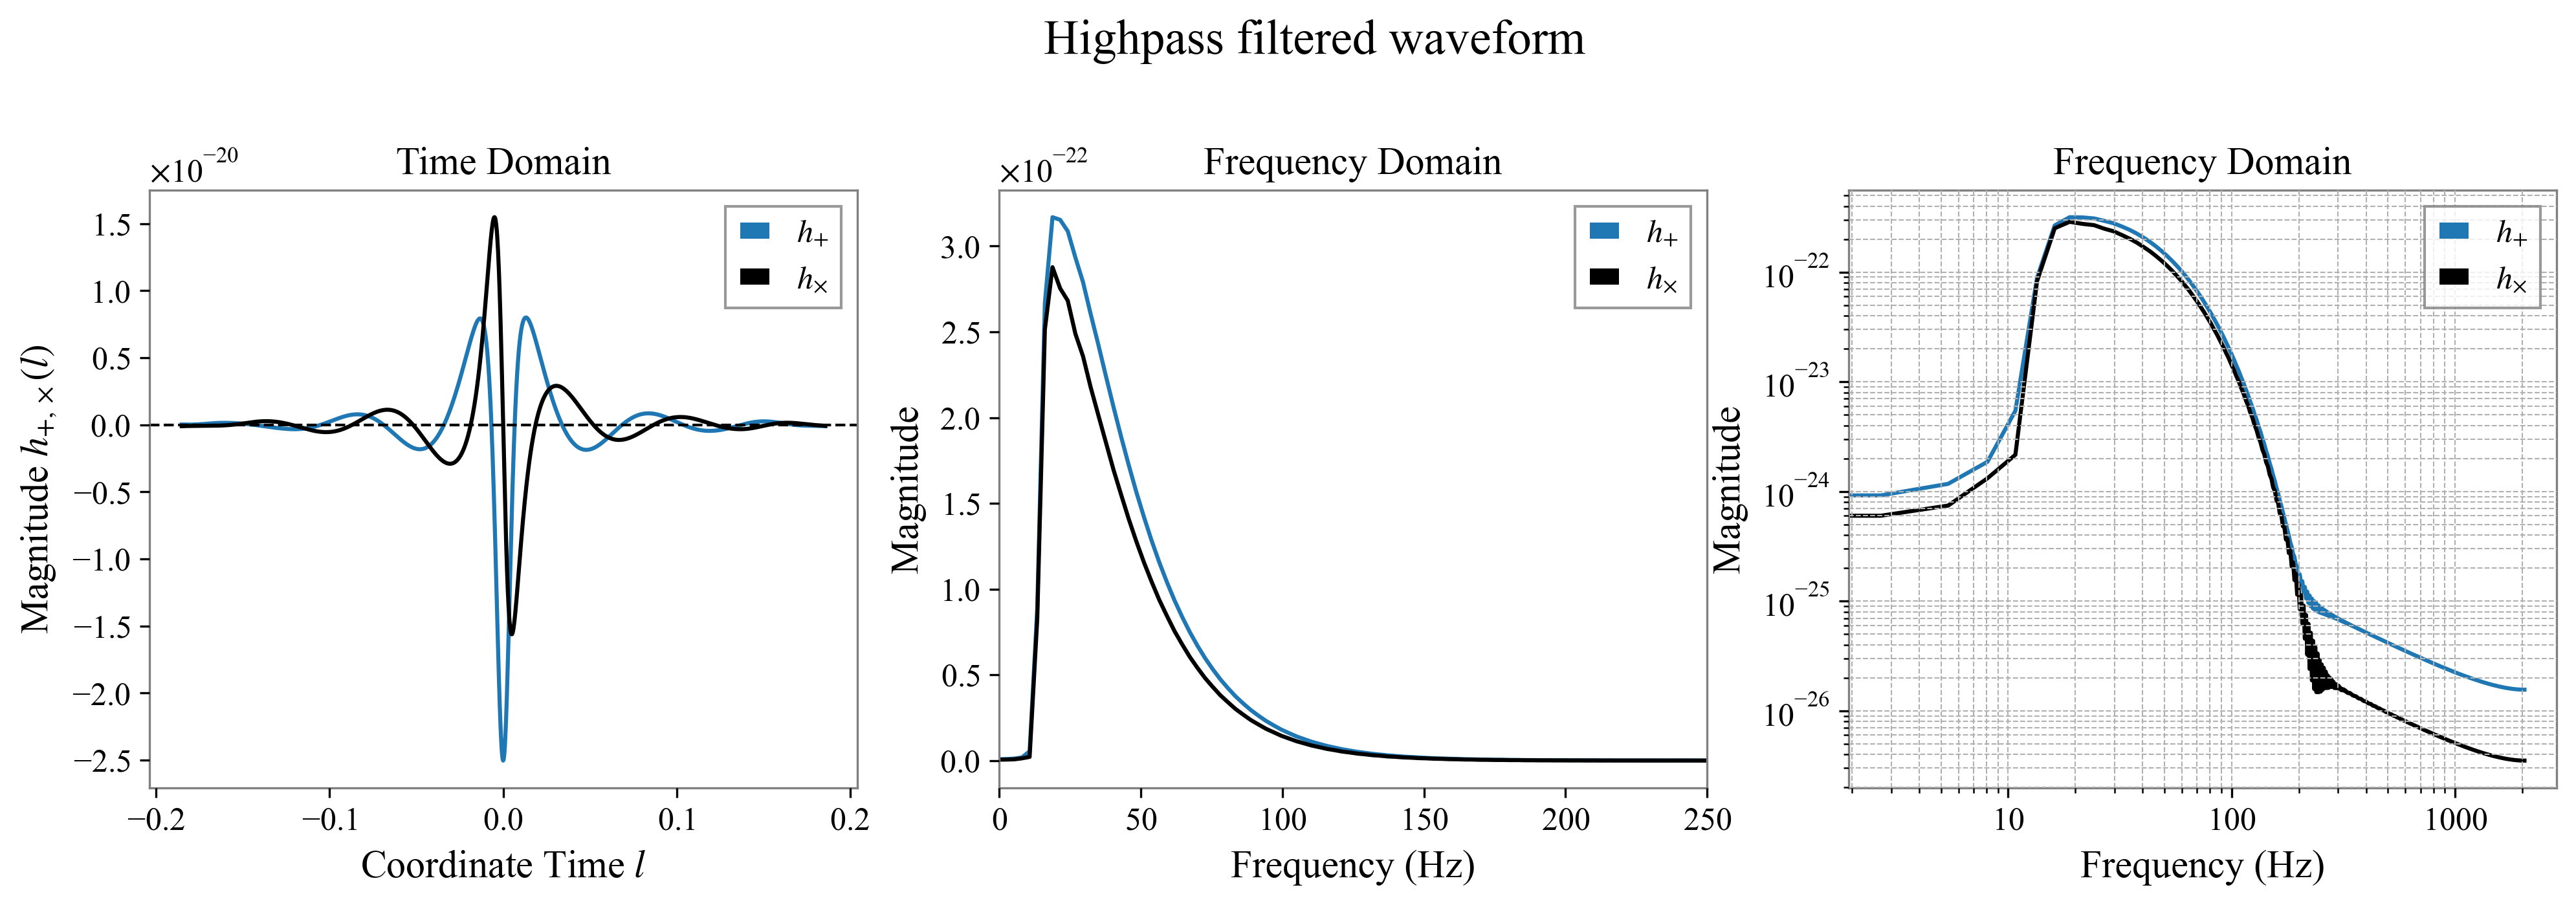

In [24]:
plt.figure(figsize=(16, 4), dpi =300)

plt.subplot(1, 3, 1)
plt.plot(hp_ts_fir.sample_times, hp_ts_fir, label=r"$h_{+}$")
plt.plot(hc_ts_fir.sample_times, hc_ts_fir, color = "black", label=r"$h_{\times}$")
plt.xlabel(r"Coordinate Time $l$")
plt.ylabel(r"Magnitude $h_{+,\times}(l)$")
plt.axhline(0, color='black', linestyle='--', linewidth=1.0)
plt.title("Time Domain")
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hp_fs_fir.sample_frequencies, abs(hp_fs_fir), label=r"$h_{+}$")
plt.plot(hc_fs_fir.sample_frequencies, abs(hc_fs_fir), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.xlim(0, 250)
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 3)
plt.loglog(hp_fs_fir.sample_frequencies, abs(hp_fs_fir), label=r"$h_{+}$")
plt.loglog(hc_fs_fir.sample_frequencies, abs(hc_fs_fir), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.suptitle("Highpass filtered waveform", fontsize=18, y=1.1)
plt.show()

### generate noise

based on the filtered time series waveform

In [602]:
# check psd type
pycbc.psd.analytical.get_lalsim_psd_list()

['AdVBNSOptimizedSensitivityP1200087',
 'AdVDesignSensitivityP1200087',
 'AdVEarlyHighSensitivityP1200087',
 'AdVEarlyLowSensitivityP1200087',
 'AdVLateHighSensitivityP1200087',
 'AdVLateLowSensitivityP1200087',
 'AdVMidHighSensitivityP1200087',
 'AdVMidLowSensitivityP1200087',
 'AdVO3LowT1800545',
 'AdVO4IntermediateT1800545',
 'AdVO4T1800545',
 'AdvVirgo',
 'CosmicExplorerP1600143',
 'CosmicExplorerPessimisticP1600143',
 'CosmicExplorerWidebandP1600143',
 'EinsteinTelescopeP1600143',
 'GEO',
 'GEOHF',
 'KAGRA',
 'KAGRA128MpcT1800545',
 'KAGRA25MpcT1800545',
 'KAGRA80MpcT1800545',
 'KAGRADesignSensitivityT1600593',
 'KAGRAEarlySensitivityT1600593',
 'KAGRALateSensitivityT1600593',
 'KAGRAMidSensitivityT1600593',
 'KAGRAOpeningSensitivityT1600593',
 'TAMA',
 'Virgo',
 'aLIGO140MpcT1800545',
 'aLIGO175MpcT1800545',
 'aLIGOAPlusDesignSensitivityT1800042',
 'aLIGOAdVO3LowT1800545',
 'aLIGOAdVO4IntermediateT1800545',
 'aLIGOAdVO4T1800545',
 'aLIGOBHBH20Deg',
 'aLIGOBHBH20DegGWINC',
 'aLIGO

In [26]:
psd = aLIGOZeroDetHighPower(len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, low_freq_cutoff=10.0)
print(len(hp_ts_fir))
noise = noise_from_psd(len(hp_ts_fir), hp_ts_fir.delta_t, psd, seed=333)
noise_ts = TimeSeries(noise.data, delta_t=noise.delta_t, epoch=hp_ts_fir.start_time)
noise_fs = noise_ts.to_frequencyseries()
signal_ts = hp_ts_fir + noise_ts
signal_fs = hp_fs_fir + noise_fs

1521


In [28]:
psd_et = pycbc.psd.from_txt('ET_D_sum_psd.txt', len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, 
                            low_freq_cutoff=10.0, is_asd_file=True)
noise_et = noise_from_psd(len(hp_ts_fir), hp_ts_fir.delta_t, psd_et, seed=333)
noise_et_ts = TimeSeries(noise_et.data, delta_t=noise_et.delta_t, epoch=hp_ts_fir.start_time)
noise_et_fs = noise_et_ts.to_frequencyseries()
signal_et_ts = hp_ts_fir + noise_et_ts
signal_et_fs = hp_fs_fir + noise_et_fs

In [30]:
psd_ce = pycbc.psd.from_txt('CE_2_psd.txt', len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, 
                            low_freq_cutoff=10.0, is_asd_file=True)
noise_ce = noise_from_psd(len(hp_ts_fir), hp_ts_fir.delta_t, psd_ce, seed=333)
noise_ce_ts = TimeSeries(noise_ce.data, delta_t=noise_ce.delta_t, epoch=hp_ts_fir.start_time)
noise_ce_fs = noise_ce_ts.to_frequencyseries()
signal_ce_ts = hp_ts_fir + noise_ce_ts
signal_ce_fs = hp_fs_fir + noise_ce_fs

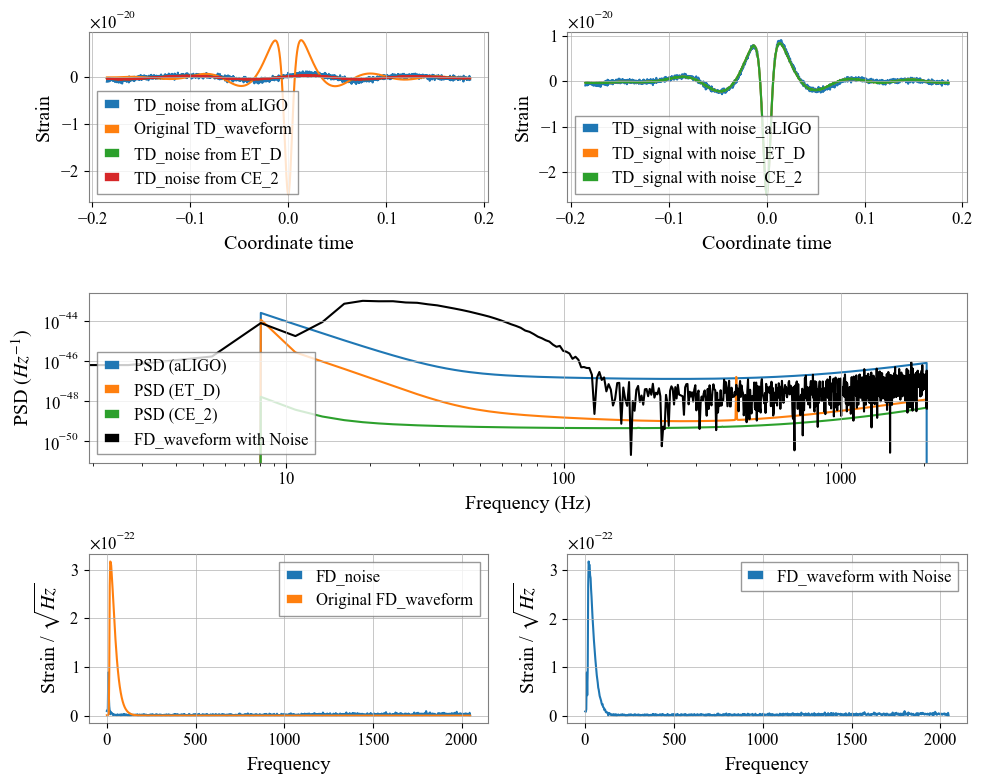

In [34]:
plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1)
plt.plot(noise_ts.sample_times, noise_ts, label="TD_noise from aLIGO")
plt.plot(hp_ts_fir.sample_times, hp_ts_fir, label="Original TD_waveform")
plt.plot(noise_et_ts.sample_times, noise_et_ts, label="TD_noise from ET_D")
plt.plot(noise_et_ts.sample_times, noise_et_ts, label="TD_noise from CE_2")
plt.xlabel('Coordinate time')
plt.ylabel('Strain')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(signal_ts.sample_times, signal_ts, label="TD_signal with noise_aLIGO")
plt.plot(signal_et_ts.sample_times, signal_et_ts, label="TD_signal with noise_ET_D")
plt.plot(signal_et_ts.sample_times, signal_et_ts, label="TD_signal with noise_CE_2")
plt.xlabel('Coordinate time')
plt.ylabel('Strain')
plt.legend()

plt.subplot(3, 1, 2)
plt.loglog(psd.sample_frequencies, psd, label='PSD (aLIGO)')
plt.loglog(psd_et.sample_frequencies, psd_et, label='PSD (ET_D)')
plt.loglog(psd_ce.sample_frequencies, psd_ce, label='PSD (CE_2)')
plt.loglog(signal_fs.sample_frequencies, abs(signal_fs)**2, color = "black", label="FD_waveform with Noise")
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Hz^{-1}$)')
plt.legend()
plt.minorticks_on()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(noise_fs.sample_frequencies, abs(noise_fs), label="FD_noise")
plt.plot(hp_fs_fir.sample_frequencies, abs(hp_fs_fir), label="Original FD_waveform")
plt.xlabel('Frequency')
plt.ylabel(r'Strain / $\sqrt{Hz}$ ')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(signal_fs.sample_frequencies, abs(signal_fs), label="FD_waveform with Noise")
plt.xlabel('Frequency')
plt.ylabel(r'Strain / $\sqrt{Hz}$')
plt.legend()

plt.tight_layout()
plt.savefig('waveform_strain.png', dpi=300, bbox_inches='tight')
plt.show()

### SNR 

In [36]:
signal_ts = hp_ts_fir + noise_ts
signal_fs = hp_fs_fir + noise_fs
snr = matched_filter(hp_fs_fir, signal_fs, psd=psd, low_frequency_cutoff=10.0)
max_snr = abs(snr).max()
print(max_snr)

404.8018489805843


In [38]:
signal_et_ts = hp_ts_fir + noise_et_ts
signal_et_fs = hp_fs_fir + noise_et_fs
snr = matched_filter(hp_fs_fir, signal_et_fs, psd=psd_et, low_frequency_cutoff=10.0)
max_snr = abs(snr).max()
print(max_snr)

signal_ce_ts = hp_ts_fir + noise_ce_ts
signal_ce_fs = hp_fs_fir + noise_ce_fs
snr = matched_filter(hp_fs_fir, signal_ce_fs, psd=psd_ce, low_frequency_cutoff=10.0)
max_snr = abs(snr).max()
print(max_snr)

3131.4943467385847
12433.626122420159


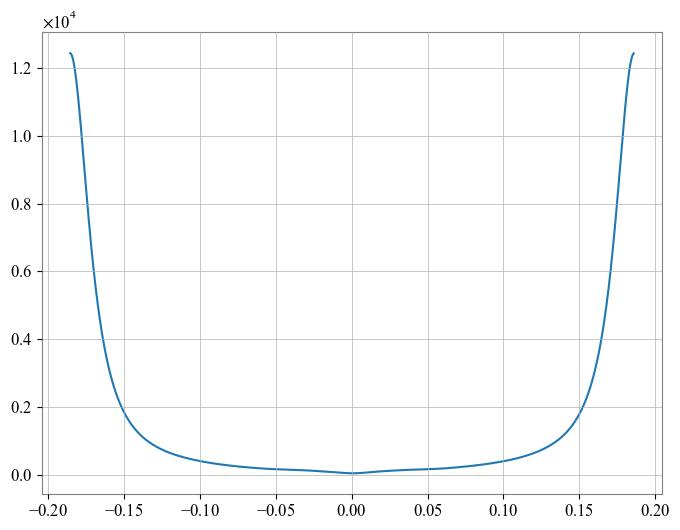

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(snr.sample_times, abs(snr))

### Class HyperbolicGW

In [47]:
from dataclasses import dataclass, field
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd.analytical import EinsteinTelescopeP1600143
from pycbc.noise import noise_from_psd
from pycbc.filter import matched_filter
from pycbc.filter import highpass
%matplotlib inline

@dataclass
class HyperbolicGW:
    m1: float
    m2: float
    hyp_ecc: float
    b: float
    distance: float
    inclination: float
    deltaT: float = 1.0 / 4096
    f_min: float = 20
    f_ref: float = 20
    _args: dict = field(init=False, repr=False)
    
    def __post_init__(self):
        self._args = {
            "m1": self.m1 * lal.MSUN_SI,
            "m2": self.m2 * lal.MSUN_SI,
            "s1x": 0, "s1y": 0, "s1z": 0, 
            "s2x": 0, "s2y": 0, "s2z": 0, 
            "distance": self.distance * lal.PC_SI,
            "inclination": self.inclination,
            "phiRef": 0,
            "longAscNodes": 0,
            "eccentricity": 0,
            "meanPerAno": 0,
            "deltaT": self.deltaT,
            "f_min": self.f_min,
            "f_ref": self.f_ref,
            "params": lal.CreateDict(),
            "approximant": None
       }
        self.M = self._args["m1"] + self._args["m2"]
        self.b_SI = self.M * lal.G_SI / lal.C_SI ** 2
        self.b = self.b * self.b_SI
        self.e = self.hyp_ecc
        
        self.psd_type = "aligo" 
        self.seed = 333
        

    @property
    def args(self):
        return self._args

    def _hyp_params(self):
        self._args["approximant"] = lalsimulation.GetApproximantFromString("HyperbolicTD")
        params = lal.CreateDict()
        lalsimulation.SimInspiralWaveformParamsInsertHyperbolicEccentricity(params, self.e)
        lalsimulation.SimInspiralWaveformParamsInsertImpactParameter(params, self.b)
        self._args["params"] = params

    def _hyp_generator(self, domain):
        self._hyp_params() 
        if domain == 'td':
            generator = lalsimulation.SimInspiralChooseTDWaveform
        elif domain == 'fd':
            generator = lalsimulation.SimInspiralChooseFDWaveform
        else:
            raise ValueError("Invalid domain: choose 'td' for time-domain or 'fd' for frequency-domain")
           
        hp, hc = generator(*list(self._args.values()))
        
        return hp, hc
        
    def td_waveform(self):
        hp, hc = self._hyp_generator(domain='td')
         # time series
        hp_ts = TimeSeries(hp.data.data[:], delta_t=hp.deltaT, epoch=hp.epoch)
        hc_ts = TimeSeries(hc.data.data[:], delta_t=hc.deltaT, epoch=hc.epoch)
        return hp_ts, hc_ts

    def _convert_to_fd(self, hpt, hct):
        hpf = FrequencySeries(np.zeros(len(hpt)//2 + 1, dtype=np.complex128), delta_f=1.0/hpt.duration)
        hcf = FrequencySeries(np.zeros(len(hct)//2 + 1, dtype=np.complex128), delta_f=1.0/hct.duration)
        fft(hpt, hpf)
        fft(hct, hcf)
        return hpf, hcf
        
    def fd_waveform(self):
        #hp, hc = self._hyp_generator(domain='fd')
        # frequency series
        #hp_fs = FrequencySeries(hp.data.data[:], delta_f=hp.deltaF, epoch=hp.epoch)
        #hc_fs = FrequencySeries(hc.data.data[:], delta_f=hc.deltaF, epoch=hc.epoch)
        
        hp_fs, hc_fs = self._convert_to_fd(*(self.td_waveform()))
        return hp_fs, hc_fs

    def _hyp_filter(self, domain):
        hp_ts_fir, hc_ts_fir = highpass(self.td_waveform()[0], 10.0), highpass(self.td_waveform()[1], 10.0)
        if domain == 'td':
            return hp_ts_fir, hc_ts_fir
        elif domain == 'fd':
            hp_fs_fir, hc_fs_fir = self._convert_to_fd(hp_ts_fir, hc_ts_fir)
            return hp_fs_fir, hc_fs_fir
        else:
            raise ValueError("Invalid domain: choose 'td' for time-domain or 'fd' for frequency-domain")
        

    def hyp_psd(self):
        hp_fs_fir, hc_fs_fir = self._hyp_filter('fd')
        if self.psd_type == "aligo":
            psd = aLIGOZeroDetHighPower(len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, low_freq_cutoff=10.0)
        elif self.psd_type == "et":
            psd = pycbc.psd.from_txt('ET_D_sum_psd.txt', len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, 
                            low_freq_cutoff=10.0, is_asd_file=True)
        elif self.psd_type == "ce":
            psd = pycbc.psd.from_txt('CE_2_psd.txt', len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, 
                            low_freq_cutoff=10.0, is_asd_file=True)
        else:
            raise ValueError("Invalid PSD type specified.")
        return psd
        
    def hyp_noise(self):
        hp_ts_fir, hc_ts_fir = self._hyp_filter('td')
        psd = self.hyp_psd()
        noise = noise_from_psd(len(hp_ts_fir), hp_ts_fir.delta_t, psd, seed=self.seed)
        noise_ts = TimeSeries(noise.data, delta_t=noise.delta_t, epoch=hp_ts_fir.start_time)
        noise_fs = noise_ts.to_frequencyseries()
        return noise_ts, noise_fs

    def hyp_snr(self):
        try:
            hp_fs_fir, hc_fs_fir = self._hyp_filter('fd')
            noise_ts, noise_fs = self.hyp_noise()
            signal_fs = hp_fs_fir + noise_fs
            psd = self.hyp_psd()
            snr = matched_filter(hp_fs_fir, signal_fs, psd=psd, low_frequency_cutoff=10.0)
            max_snr = abs(snr).max()
            return max_snr
        except RuntimeError as err:
            print(f"Error occurred for b={self.b/self.b_SI}, e={self.e}: {err}")
            return None
        

In [49]:
class detector_ALIGO(HyperbolicGW):
    def __init__(self, m1, m2, hyp_ecc, b, distance, inclination):
        super().__init__(m1, m2, hyp_ecc, b, distance, inclination)
        self.psd_type = "aligo"  # default

class detector_ETD(HyperbolicGW):
    def __init__(self, m1, m2, hyp_ecc, b, distance, inclination):
        super().__init__(m1, m2, hyp_ecc, b, distance, inclination)
        self.psd_type = "et" 

class detector_CE2(HyperbolicGW):
    def __init__(self, m1, m2, hyp_ecc, b, distance, inclination):
        super().__init__(m1, m2, hyp_ecc, b, distance, inclination)
        self.psd_type = "ce" 

In [51]:
class HyperAnalysis(HyperbolicGW):
    def __init__(self, m1, m2, hyp_ecc, b, distance, inclination, 
                 detector, seed):
        super().__init__(m1, m2, hyp_ecc, b, distance, inclination)
        self.b_min = 30
        self.b_max = 70
        self.e_min = 1.05
        self.e_max = 1.5
        self.psd_type = detector
        self.seed = seed

    def snr_b(self):
        b_values = np.arange(self.b_min, self.b_max + 1, 1)
        for b in b_values:
            self.b = b
            print(f"Assigned self.b = {self.b}") 
     

In [55]:
test1 = HyperAnalysis(10, 10, 1.1, 100, 1.6e6, np.pi/3, "aligo", 333)
snr1 = test1.hyp_snr()

test2 = detector_ETD(10, 10, 1.1, 100, 1.6e6, np.pi/3)
snr2 = test2.hyp_snr()

test3 = detector_CE2(10, 10, 1.1, 100, 1.6e6, np.pi/3)
snr3 = test3.hyp_snr()
snr1, snr2, snr3

(404.8018489805843, 3131.4943467385847, 12433.626122420159)

In [88]:
def snr_b(b_values, detector, ecc=1.1):
    snr_b = []
    valid_b = []
    error_b = []

    if detector == "aligo":
        detector_class = detector_ALIGO
    elif detector == "et":
        detector_class = detector_ETD
    elif detector == "ce":
        detector_class = detector_CE2
    else:
        raise ValueError("Invalid detector specified. Use 'aligo', 'et' or 'ce'.")

    
    start_time = time.time()
    for i, b in enumerate(b_values):
        test = detector_class(10, 10, ecc, b, 1.6e6, np.pi/3)
        snr = test.hyp_snr()

        if snr is not None:
            snr_b.append(snr)
            valid_b.append(b)
        else:
            error_b.append(b)

        if (i + 1) % 10 == 0:
            elapsed_time = time.time() - start_time
            estimated_time_remaining = (len(b_values) - (i + 1)) * (elapsed_time / (i + 1))
            print(f"Progress: {i + 1} out of {len(b_values)} b values calculated.")
            print(f"Estimated time remaining: {estimated_time_remaining:.2f} seconds")


    return snr_b, valid_b, error_b

In [90]:
def snr_e(e_values, detector, b=100):
    snr_e = []
    valid_e = []
    error_e = []

    if detector == "aligo":
        detector_class = detector_ALIGO
    elif detector == "et":
        detector_class = detector_ETD
    elif detector == "ce":
        detector_class = detector_CE2
    else:
        raise ValueError("Invalid detector specified. Use 'aligo', 'et' or 'ce'.")

    
    start_time = time.time()
    for i, e in enumerate(e_values):
        test = detector_class(10, 10, e, 100, 1.6e6, np.pi/3)
        snr = test.hyp_snr()

        if snr is not None:
            snr_e.append(snr)
            valid_e.append(e)
        else:
            error_e.append(e)

        if (i + 1) % 10 == 0:
            elapsed_time = time.time() - start_time
            estimated_time_remaining = (len(e_values) - (i + 1)) * (elapsed_time / (i + 1))
            print(f"Progress: {i + 1} out of {len(e_values)} ecc values calculated.")
            print(f"Estimated time remaining: {estimated_time_remaining:.2f} seconds")
    return snr_e, valid_e, error_e

In [77]:
def snr_e_sd(detector, e_list, seed_list, b=100):
    snr_e_mean = []
    snr_e_sd = []
    for e in e_list:
        snr_values = []
        for seed in seed_list:
            test = HyperAnalysis(10, 10, e, 100, 1.6e6, np.pi/3, detector, seed)
            snr = test.hyp_snr()         
            snr_values.append(snr)
            
        snr_mean = np.mean(snr_values)
        snr_e_mean.append(snr_mean)
        snr_sd = np.std(snr_values)
        snr_e_sd.append(snr_sd)

    return snr_e_mean, snr_e_sd

In [79]:
snr_e_mean_aligo, snr_e_sd_aligo = snr_e_sd("aligo", e_list, seed_list, b=100)
snr_e_mean_et, snr_e_sd_et = snr_e_sd("et", e_list, seed_list, b=100)
snr_e_mean_ce, snr_e_sd_ce = snr_e_sd("ce", e_list, seed_list, b=100)

In [70]:
valid_b, snr_b_mean_ce, snr_b_sd_ce = wrapper_snr_b_sd("ce", b_list, seed_list, e=1.1)

Progress: 1 out of 47 b values processed.
Progress: 2 out of 47 b values processed.
Progress: 3 out of 47 b values processed.
Progress: 4 out of 47 b values processed.
Progress: 5 out of 47 b values processed.
Progress: 6 out of 47 b values processed.
Progress: 7 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument
Progress: 8 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument
No valid SNR values for b = 120. Skipping this b value.
Progress: 9 out of 47 b values processed.
Progress: 10 out of 47 b values processed.
Progress: 11 out of 47 b values processed.
Progress: 12 out of 47 b values processed.
Progress: 13 out of 47 b values processed.
Progress: 14 out of 47 b values processed.
Progress: 15 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument
Progress: 16 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument
No valid SNR values for b = 160. Skipping this b value.
Progress: 17 out of 47 b values processed.
Progress: 18 out of 47 b values processed.
Progress: 19 out of 47 b values processed.
Progress: 20 out of 47 b values processed.
Progress: 21 out of 47 b values processed.
Progress: 22 out of 47 b values processed.
Progress: 23 out of 47 b values processed.
Progress: 24 out of 47 b values processed.
Progress: 25 out of 47 b values processed.
Progress: 26 out of 47 b values processed.
Progress: 27 out of 47 b values processed.
Progress: 28 out of 47 b values processed.
Progress: 29 out of 47 b values processed.
Progress: 30 out of 47 b values processed.
Progress: 31 out of 47 b values processed.
Progress: 32 out of 47 b values processed.
Progress: 33 out of 47 b values processed.
Progress: 34 out of 47 b values processed.
Progress: 35 out of 47 b values processed.
Progress: 36 out of 47 b values processed.
Progress: 37 out of

In [61]:
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def calculate_snr_b_sd(detector, b, seed_list, e=1.1):
    snr_values = []
    for seed in seed_list:
        test = HyperAnalysis(10, 10, 1.1, b, 1.6e6, np.pi/3, detector, seed)
        snr = test.hyp_snr() 
        if snr is not None:
            snr_values.append(snr)
    
    if len(snr_values) == 0:
        print(f"No valid SNR values for b = {b}. Skipping this b value.")
        return None, None
    
    snr_mean = np.mean(snr_values)
    snr_sd = np.std(snr_values)
    
    return snr_mean, snr_sd

def wrapper_snr_b_sd(detector, b_list, seed_list, e=1.1):
    snr_b_mean = []
    snr_b_sd = []
    valid_b = [] 

    start_time = time.time()
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(calculate_snr_b_sd, detector, b, seed_list, e): b for b in b_list}
        
        for i, future in enumerate(as_completed(futures)):
            b = futures[future]
            try:
                snr_mean, snr_sd = future.result()
                if snr_mean is not None:
                    snr_b_mean.append(snr_mean)
                    snr_b_sd.append(snr_sd)
                    valid_b.append(b)
            except Exception as exc:
                print(f"b = {b} generated an exception: {exc}")

            print(f"Progress: {i + 1} out of {len(b_list)} b values processed.")
            
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total elapsed time: {elapsed_time:.2f} seconds")
    return valid_b, snr_b_mean, snr_b_sd

In [67]:
valid_b, snr_b_mean_aligo, snr_b_sd_aligo = wrapper_snr_b_sd("aligo", b_list, seed_list, e=1.1)

Progress: 1 out of 47 b values processed.
Progress: 2 out of 47 b values processed.
Progress: 3 out of 47 b values processed.
Progress: 4 out of 47 b values processed.
Progress: 5 out of 47 b values processed.
Progress: 6 out of 47 b values processed.
Progress: 7 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument
Progress: 8 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument
No valid SNR values for b = 120. Skipping this b value.
Progress: 9 out of 47 b values processed.
Progress: 10 out of 47 b values processed.
Progress: 11 out of 47 b values processed.
Progress: 12 out of 47 b values processed.
Progress: 13 out of 47 b values processed.
Progress: 14 out of 47 b values processed.
Progress: 15 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument
Progress: 16 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument
No valid SNR values for b = 160. Skipping this b value.
Progress: 17 out of 47 b values processed.
Progress: 18 out of 47 b values processed.
Progress: 19 out of 47 b values processed.
Progress: 20 out of 47 b values processed.
Progress: 21 out of 47 b values processed.
Progress: 22 out of 47 b values processed.
Progress: 23 out of 47 b values processed.
Progress: 24 out of 47 b values processed.
Progress: 25 out of 47 b values processed.
Progress: 26 out of 47 b values processed.
Progress: 27 out of 47 b values processed.
Progress: 28 out of 47 b values processed.
Progress: 29 out of 47 b values processed.
Progress: 30 out of 47 b values processed.
Progress: 31 out of 47 b values processed.
Progress: 32 out of 47 b values processed.
Progress: 33 out of 47 b values processed.
Progress: 34 out of 47 b values processed.
Progress: 35 out of 47 b values processed.
Progress: 36 out of 47 b values processed.
Progress: 37 out of

In [65]:
b_list = np.arange(70, 301, 5)
e_list = np.arange(1.05, 1.51, 0.01)
np.random.seed(42)
seed_list = np.random.choice(range(1000), size=10, replace=False)
seed_list

array([521, 737, 740, 660, 411, 678, 626, 513, 859, 136])

In [69]:
valid_b, snr_b_mean_et, snr_b_sd_et = wrapper_snr_b_sd("et", b_list, seed_list, e=1.1)

Progress: 1 out of 47 b values processed.
Progress: 2 out of 47 b values processed.
Progress: 3 out of 47 b values processed.
Progress: 4 out of 47 b values processed.
Progress: 5 out of 47 b values processed.
Progress: 6 out of 47 b values processed.
Progress: 7 out of 47 b values processed.
Progress: 8 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.0, e=1.1: Invalid argument
No valid SNR values for b = 120. Skipping this b value.
Progress: 9 out of 47 b values processed.
Progress: 10 out of 47 b values processed.
Progress: 11 out of 47 b values processed.
Progress: 12 out of 47 b values processed.
Progress: 13 out of 47 b values processed.
Progress: 14 out of 47 b values processed.
Progress: 15 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument
Progress: 16 out of 47 b values processed.


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=159.99999999999997, e=1.1: Invalid argument
No valid SNR values for b = 160. Skipping this b value.
Progress: 17 out of 47 b values processed.
Progress: 18 out of 47 b values processed.
Progress: 19 out of 47 b values processed.
Progress: 20 out of 47 b values processed.
Progress: 21 out of 47 b values processed.
Progress: 22 out of 47 b values processed.
Progress: 23 out of 47 b values processed.
Progress: 24 out of 47 b values processed.
Progress: 25 out of 47 b values processed.
Progress: 26 out of 47 b values processed.
Progress: 27 out of 47 b values processed.
Progress: 28 out of 47 b values processed.
Progress: 29 out of 47 b values processed.
Progress: 30 out of 47 b values processed.
Progress: 31 out of 47 b values processed.
Progress: 32 out of 47 b values processed.
Progress: 33 out of 47 b values processed.
Progress: 34 out of 47 b values processed.
Progress: 35 out of 47 b values processed.
Progress: 36 out of 47 b values processed.
Progress: 37 out of

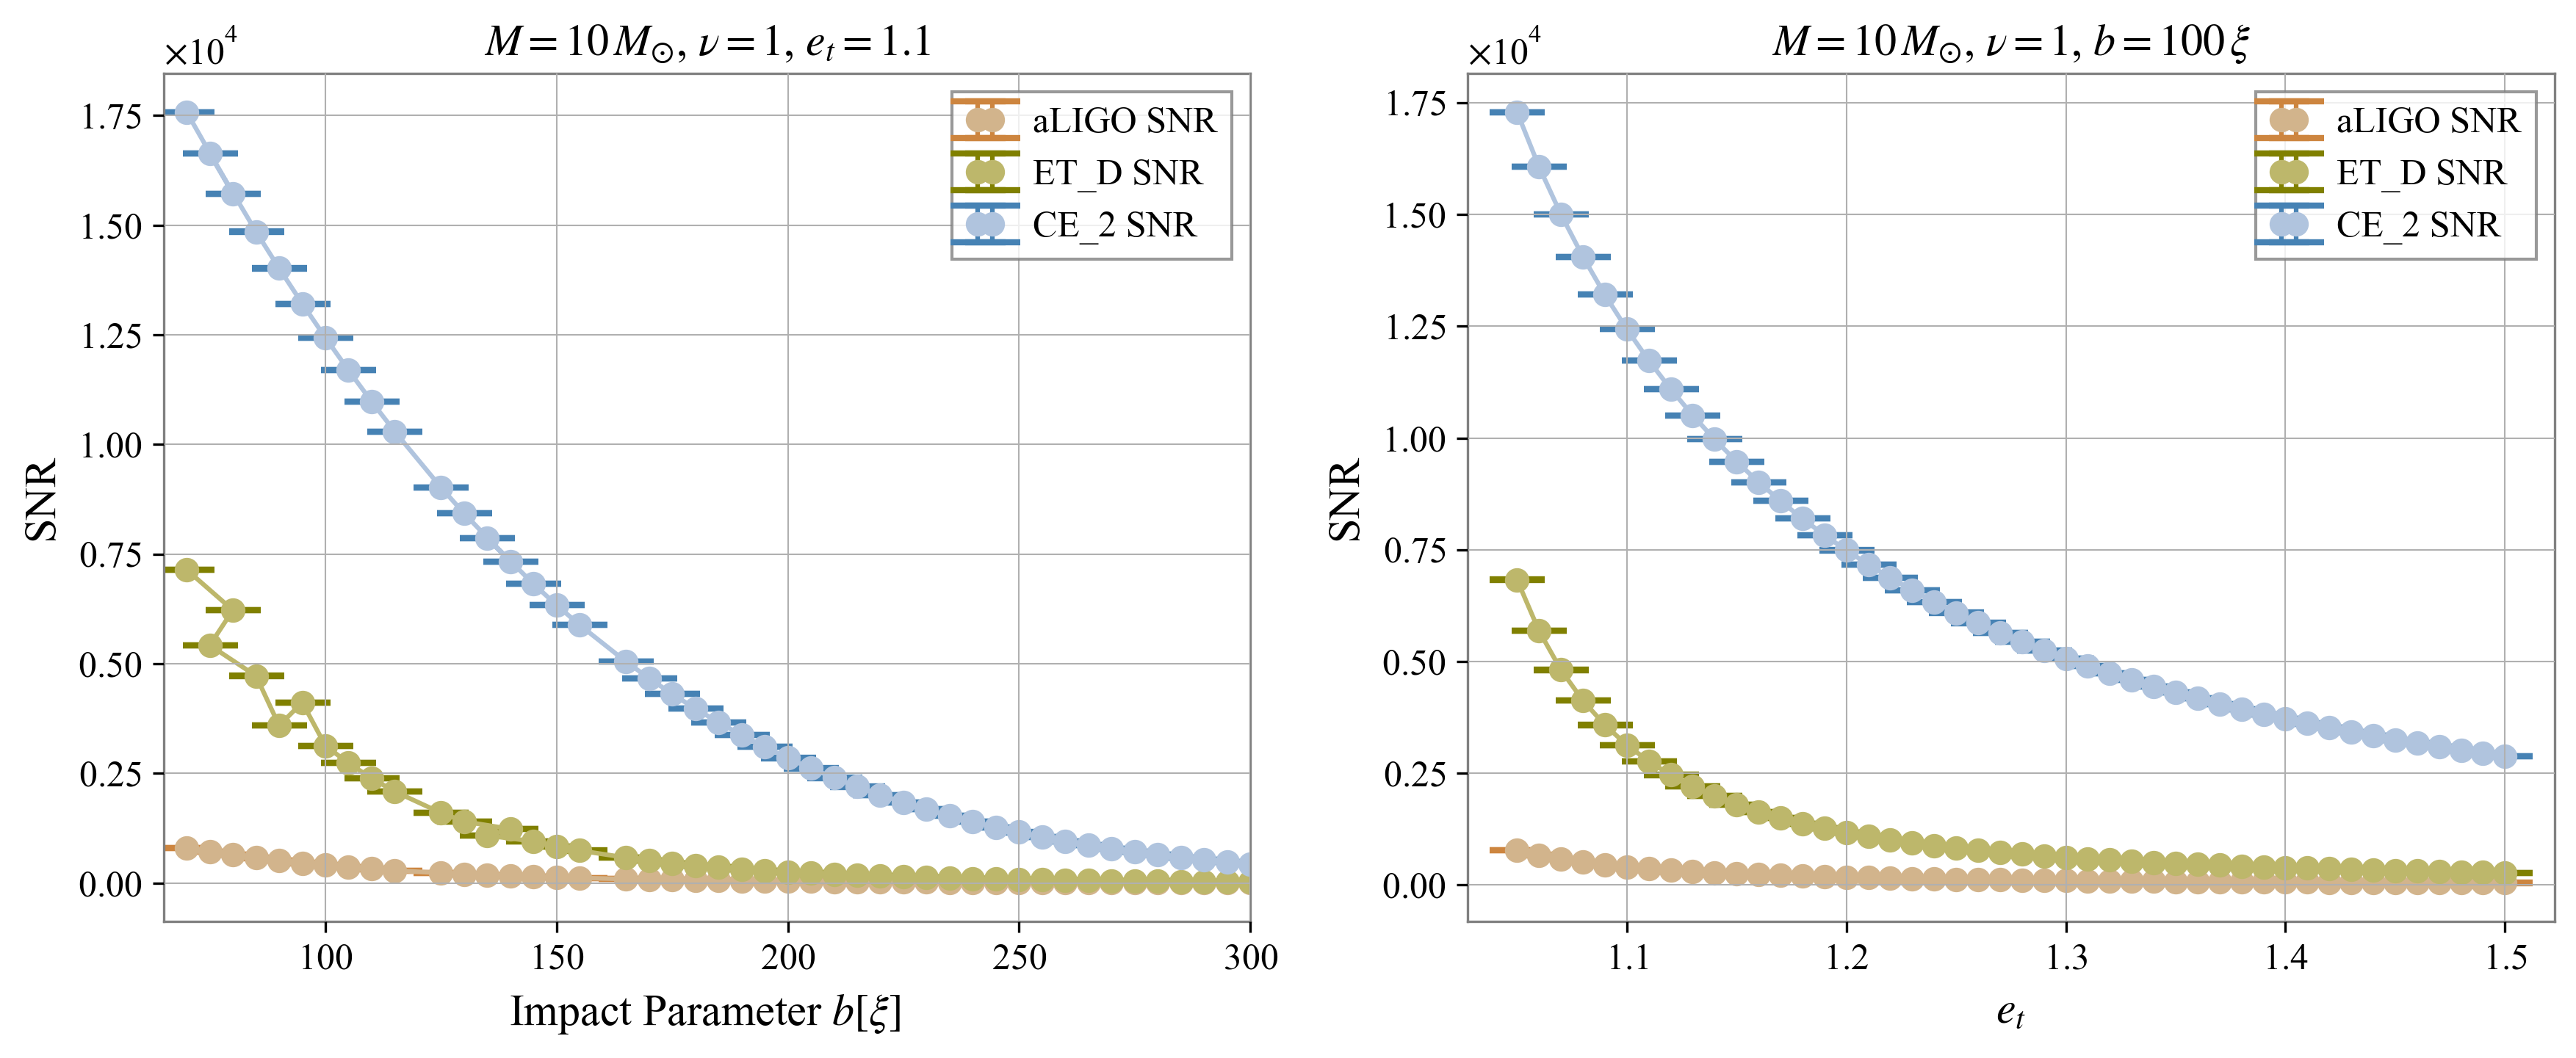

In [86]:
plt.figure(figsize=(14, 5), dpi =300)

plt.subplot(1, 2, 1)
plt.errorbar(valid_b, snr_b_mean_aligo, yerr=snr_b_sd_aligo, xerr = None, fmt='o', ecolor='peru',
             capsize=9, capthick=2, markersize=7, linestyle='-', color='tan', label='aLIGO SNR')
plt.errorbar(valid_b, snr_b_mean_et, yerr=snr_b_sd_et, xerr = None, fmt='o', ecolor='olive',
             capsize=9, capthick=2, markersize=7, linestyle='-', color='darkkhaki', label='ET_D SNR')
plt.errorbar(valid_b, snr_b_mean_ce, yerr=snr_b_sd_ce, xerr = None, fmt='o', ecolor='steelblue',
             capsize=9, capthick=2, markersize=7, linestyle='-', color='lightsteelblue', label='CE_2 SNR')
plt.xlim(65,300)
plt.xlabel(r'Impact Parameter $b [\xi]$ ')
plt.ylabel('SNR')
plt.title(r'$M = 10\, M_{\odot}$, $\nu =1$, $e_{t} = 1.1$')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(e_list, snr_e_mean_aligo, yerr=snr_e_sd_aligo, xerr = None, fmt='o', ecolor='peru',
             capsize=9, capthick=2, markersize=7, linestyle='-', color='tan', label='aLIGO SNR')
plt.errorbar(e_list, snr_e_mean_et, yerr=snr_e_sd_et, xerr = None, fmt='o', ecolor='olive',
             capsize=9, capthick=2, markersize=7, linestyle='-', color='darkkhaki', label='ET_D SNR')
plt.errorbar(e_list, snr_e_mean_ce, yerr=snr_e_sd_ce, xerr = None, fmt='o', ecolor='steelblue',
             capsize=9, capthick=2, markersize=7, linestyle='-', color='lightsteelblue', label='CE_2 SNR')
plt.xlabel(r'$e_{t}$')
plt.ylabel('SNR')
plt.title(r'$M = 10\, M_{\odot}$, $\nu =1$, $b =100 \,\xi$')
plt.legend()
plt.grid(True)

plt.savefig('snr_vs_b_err.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
b_values = np.arange(70, 301, 1)
snr_b_aligo, valid_b_aligo, error_b_aligo = snr_b(b_values, "aligo", ecc=1.1)

Progress: 10 out of 231 b values calculated.
Estimated time remaining: 29.08 seconds
Progress: 20 out of 231 b values calculated.
Estimated time remaining: 30.06 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=96.0, e=1.1: Invalid argument
Error occurred for b=97.0, e=1.1: Invalid argument
Progress: 30 out of 231 b values calculated.
Estimated time remaining: 28.48 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=103.0, e=1.1: Invalid argument
Progress: 40 out of 231 b values calculated.
Estimated time remaining: 26.95 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=112.00000000000001, e=1.1: Invalid argument
Progress: 50 out of 231 b values calculated.
Estimated time remaining: 25.71 seconds
Error occurred for b=120.0, e=1.1: Invalid argument
Error occurred for b=121.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Progress: 60 out of 231 b values calculated.
Estimated time remaining: 24.43 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=134.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=137.0, e=1.1: Invalid argument
Error occurred for b=138.0, e=1.1: Invalid argument
Progress: 70 out of 231 b values calculated.
Estimated time remaining: 22.99 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=149.0, e=1.1: Invalid argument
Progress: 80 out of 231 b values calculated.
Estimated time remaining: 21.77 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=153.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=156.0, e=1.1: Invalid argument
Progress: 90 out of 231 b values calculated.
Estimated time remaining: 20.69 seconds
Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=162.0, e=1.1: Invalid argument
Progress: 100 out of 231 b values calculated.
Estimated time remaining: 19.52 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=172.0, e=1.1: Invalid argument
Progress: 110 out of 231 b values calculated.
Estimated time remaining: 18.25 seconds
Progress: 120 out of 231 b values calculated.
Estimated time remaining: 16.95 seconds
Progress: 130 out of 231 b values calculated.
Estimated time remaining: 15.58 seconds
Progress: 140 out of 231 b values calculated.
Estimated time remaining: 14.17 seconds
Progress: 150 out of 231 b values calculated.
Estimated time remaining: 12.75 seconds
Progress: 160 out of 231 b values calculated.
Estimated time remaining: 11.27 seconds
Progress: 170 out of 231 b values calculated.
Estimated time remaining: 9.78 seconds
Progress: 180 out of 231 b values calculated.
Estimated time remaining: 8.24 seconds
Progress: 190 out of 231 b values calculated.
Estimated time remaining: 6.69 seconds
Progress: 200 out of 231 b values calculated.
Estimated time remaining: 5.13 seconds
Progress: 210 out of 231 b values calculated.
Estimated time remaining: 3.50 seconds
Progres

In [81]:
snr_b_et, valid_b_et, error_b_et = snr_b(b_values, "et", ecc=1.1)

Progress: 10 out of 231 b values calculated.
Estimated time remaining: 28.35 seconds
Progress: 20 out of 231 b values calculated.
Estimated time remaining: 27.41 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=96.0, e=1.1: Invalid argument
Error occurred for b=97.0, e=1.1: Invalid argument
Progress: 30 out of 231 b values calculated.
Estimated time remaining: 26.00 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=103.0, e=1.1: Invalid argument
Progress: 40 out of 231 b values calculated.
Estimated time remaining: 24.95 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=112.00000000000001, e=1.1: Invalid argument
Progress: 50 out of 231 b values calculated.
Estimated time remaining: 23.96 seconds
Error occurred for b=120.0, e=1.1: Invalid argument
Error occurred for b=121.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Progress: 60 out of 231 b values calculated.
Estimated time remaining: 22.81 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=134.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=137.0, e=1.1: Invalid argument
Error occurred for b=138.0, e=1.1: Invalid argument
Progress: 70 out of 231 b values calculated.
Estimated time remaining: 21.63 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=149.0, e=1.1: Invalid argument
Progress: 80 out of 231 b values calculated.
Estimated time remaining: 20.53 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=153.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=156.0, e=1.1: Invalid argument
Progress: 90 out of 231 b values calculated.
Estimated time remaining: 19.42 seconds
Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=162.0, e=1.1: Invalid argument
Progress: 100 out of 231 b values calculated.
Estimated time remaining: 18.23 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=172.0, e=1.1: Invalid argument
Progress: 110 out of 231 b values calculated.
Estimated time remaining: 17.06 seconds
Progress: 120 out of 231 b values calculated.
Estimated time remaining: 15.84 seconds
Progress: 130 out of 231 b values calculated.
Estimated time remaining: 14.63 seconds
Progress: 140 out of 231 b values calculated.
Estimated time remaining: 13.34 seconds
Progress: 150 out of 231 b values calculated.
Estimated time remaining: 12.02 seconds
Progress: 160 out of 231 b values calculated.
Estimated time remaining: 10.67 seconds
Progress: 170 out of 231 b values calculated.
Estimated time remaining: 9.33 seconds
Progress: 180 out of 231 b values calculated.
Estimated time remaining: 7.86 seconds
Progress: 190 out of 231 b values calculated.
Estimated time remaining: 6.37 seconds
Progress: 200 out of 231 b values calculated.
Estimated time remaining: 4.87 seconds
Progress: 210 out of 231 b values calculated.
Estimated time remaining: 3.34 seconds
Progres

In [82]:
snr_b_ce, valid_b_ce, error_b_ce = snr_b(b_values, "ce", ecc=1.1)

Progress: 10 out of 231 b values calculated.
Estimated time remaining: 27.72 seconds
Progress: 20 out of 231 b values calculated.
Estimated time remaining: 26.72 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=96.0, e=1.1: Invalid argument
Error occurred for b=97.0, e=1.1: Invalid argument
Progress: 30 out of 231 b values calculated.
Estimated time remaining: 25.85 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=103.0, e=1.1: Invalid argument
Progress: 40 out of 231 b values calculated.
Estimated time remaining: 24.79 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=112.00000000000001, e=1.1: Invalid argument
Progress: 50 out of 231 b values calculated.
Estimated time remaining: 23.84 seconds
Error occurred for b=120.0, e=1.1: Invalid argument
Error occurred for b=121.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Progress: 60 out of 231 b values calculated.
Estimated time remaining: 22.64 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=134.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=137.0, e=1.1: Invalid argument
Error occurred for b=138.0, e=1.1: Invalid argument
Progress: 70 out of 231 b values calculated.
Estimated time remaining: 21.47 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=149.0, e=1.1: Invalid argument
Progress: 80 out of 231 b values calculated.
Estimated time remaining: 20.40 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=153.0, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=156.0, e=1.1: Invalid argument
Progress: 90 out of 231 b values calculated.
Estimated time remaining: 19.28 seconds
Error occurred for b=159.99999999999997, e=1.1: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument
XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=162.0, e=1.1: Invalid argument
Progress: 100 out of 231 b values calculated.
Estimated time remaining: 18.06 seconds


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=172.0, e=1.1: Invalid argument
Progress: 110 out of 231 b values calculated.
Estimated time remaining: 17.01 seconds
Progress: 120 out of 231 b values calculated.
Estimated time remaining: 15.80 seconds
Progress: 130 out of 231 b values calculated.
Estimated time remaining: 14.53 seconds
Progress: 140 out of 231 b values calculated.
Estimated time remaining: 13.25 seconds
Progress: 150 out of 231 b values calculated.
Estimated time remaining: 11.91 seconds
Progress: 160 out of 231 b values calculated.
Estimated time remaining: 10.53 seconds
Progress: 170 out of 231 b values calculated.
Estimated time remaining: 9.14 seconds
Progress: 180 out of 231 b values calculated.
Estimated time remaining: 7.70 seconds
Progress: 190 out of 231 b values calculated.
Estimated time remaining: 6.24 seconds
Progress: 200 out of 231 b values calculated.
Estimated time remaining: 4.76 seconds
Progress: 210 out of 231 b values calculated.
Estimated time remaining: 3.26 seconds
Progres

In [92]:
e_values = np.arange(1.05, 1.51, 0.01)
snr_e_aligo, valid_e_aligo, error_e_aligo = snr_e(e_values, "aligo", b = 100)
snr_e_et, valid_e_et, error_e_et = snr_e(e_values, "et", b = 100)
snr_e_ce, valid_e_ce, error_e_ce = snr_e(e_values, "ce", b = 100)

Progress: 10 out of 46 ecc values calculated.
Estimated time remaining: 5.53 seconds
Progress: 20 out of 46 ecc values calculated.
Estimated time remaining: 3.90 seconds
Progress: 30 out of 46 ecc values calculated.
Estimated time remaining: 2.48 seconds
Progress: 40 out of 46 ecc values calculated.
Estimated time remaining: 0.94 seconds
Progress: 10 out of 46 ecc values calculated.
Estimated time remaining: 4.88 seconds
Progress: 20 out of 46 ecc values calculated.
Estimated time remaining: 3.57 seconds
Progress: 30 out of 46 ecc values calculated.
Estimated time remaining: 2.26 seconds
Progress: 40 out of 46 ecc values calculated.
Estimated time remaining: 0.85 seconds
Progress: 10 out of 46 ecc values calculated.
Estimated time remaining: 5.46 seconds
Progress: 20 out of 46 ecc values calculated.
Estimated time remaining: 3.79 seconds
Progress: 30 out of 46 ecc values calculated.
Estimated time remaining: 2.30 seconds
Progress: 40 out of 46 ecc values calculated.
Estimated time rema

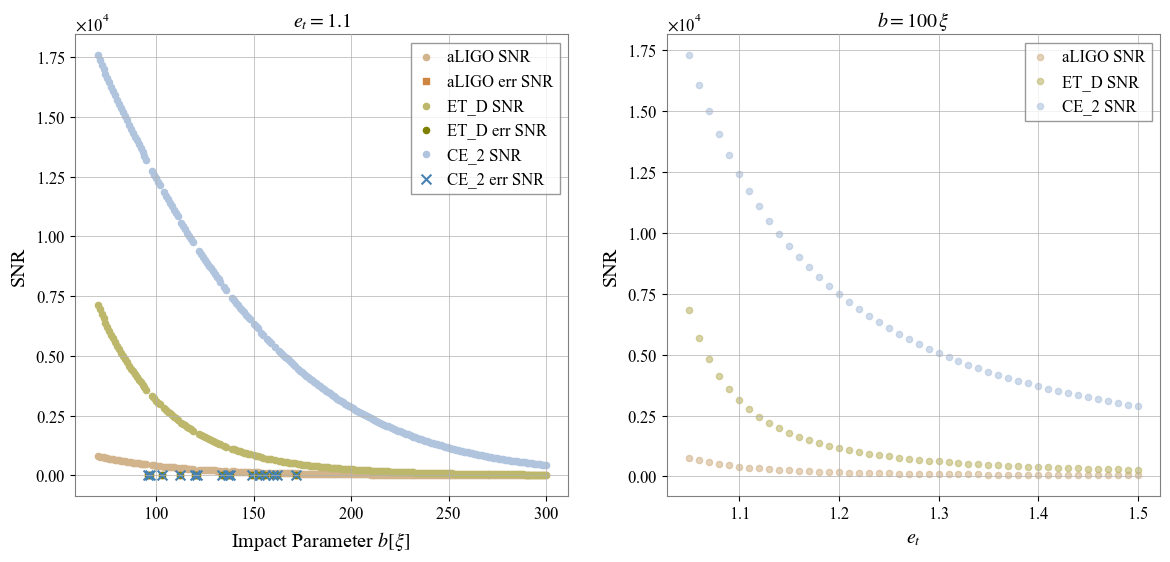

In [94]:
%matplotlib inline
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(valid_b_aligo, snr_b_aligo, marker='o', s=20, color = "tan", label='aLIGO SNR')
if error_b_aligo:
    plt.scatter(error_b_aligo, [0]*len(error_b_aligo), color='peru', marker='s', s=20, label='aLIGO err SNR')

plt.scatter(valid_b_et, snr_b_et, marker='o', s=20, color = "darkkhaki", label='ET_D SNR')
if error_b_et:
    plt.scatter(error_b_et, [0]*len(error_b_et), color='olive', marker='o', s=20, label='ET_D err SNR')

plt.scatter(valid_b_ce, snr_b_ce, marker='o', s=20, color = "lightsteelblue", label='CE_2 SNR')
if error_b_ce:
    plt.scatter(error_b_ce, [0]*len(error_b_ce), color='steelblue', marker='x', s=50, label='CE_2 err SNR')
plt.xlabel(r'Impact Parameter $b [\xi]$ ')
plt.ylabel('SNR')
plt.title(r'$e_{t} = 1.1$')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(valid_e_aligo, snr_e_aligo, marker='o', s=20, alpha = 0.6, color = "tan", label='aLIGO SNR')
plt.scatter(valid_e_et, snr_e_et, marker='o', s=20, alpha = 0.6, color = "darkkhaki", label='ET_D SNR')
plt.scatter(valid_e_ce, snr_e_ce, marker='o', s=20, alpha = 0.6, color = "lightsteelblue", label='CE_2 SNR')
plt.xlabel(r'$e_{t}$')
plt.ylabel('SNR')
plt.title(r'$b =100 \,\xi$')
plt.legend()
plt.grid(True)

plt.savefig('snr_vs_b.png', dpi=300, bbox_inches='tight')
plt.show()


### SNR distribution

In [216]:
np.random.seed(42)

def generate_b_samples(size, b_min, b_max):
    u = np.random.uniform(size=size)
    b_samples = b_max * b_min / (b_max - u * (b_max - b_min))
    return b_samples

def generate_e_samples(size, e_min, e_max):
    e_samples = np.random.uniform(e_min, e_max, size=size)
    return e_samples


In [104]:
num_samples = 1000
b_min = 70
b_max = 300
e_min = 1.05
e_max = 1.5

#b_samples = generate_b_samples(num_samples, b_min, b_max)
#e_samples = generate_e_samples(num_samples, e_min, e_max)
print(len(b_samples))

1000


In [96]:
#np.savetxt('samples.csv', np.column_stack((b_samples, e_samples)), delimiter=',', header='b_samples,e_samples', comments='')
data = np.loadtxt('samples.csv', delimiter=',', skiprows=1)
b_samples, e_samples = data[:, 0], data[:, 1]


In [98]:
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def snr_be(b, e):
    test = HyperbolicGW(10, 10, e, b, 1.6e6, np.pi/3)
    snr = test.hyp_snr()
    return snr, b, e

def wrapper_snr_be(params):
    return snr_be(*params)

In [100]:
params = list(zip(b_samples, e_samples))
total_tasks = len(params)
snr_values = []
valid_b_samples = []
valid_e_samples = []

start_time = time.time()
with ProcessPoolExecutor() as executor:
    with tqdm(total=total_tasks) as pbar:
        for i, (snr, b, e) in enumerate(executor.map(wrapper_snr_be, params)):
            if snr is not None:
                snr_values.append(snr)
                valid_b_samples.append(b)
                valid_e_samples.append(e)
            if (i + 1) % 100 == 0:
                pbar.update(100)

end_time = time.time()
elapsed_time = end_time - start_time

  0%|                                                        | 0/1000 [00:00<?, ?it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=273.0083152775375, e=1.4944506035984912: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=104.65847547362443, e=1.4619697339146187: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=90.2035775534008, e=1.4659782879194387: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=87.32512988756842, e=1.4486899867062841: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=120.5119099739878, e=1.4415444932554184: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=122.87438679719196, e=1.2807098299574289: Invalid argument


 10%|████▌                                         | 100/1000 [00:10<01:32,  9.76it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=84.89087131090585, e=1.3632092781242064: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=116.22877025535095, e=1.433043111321946: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=135.86107481133857, e=1.1079914403630504: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=136.1089477759661, e=1.200803484416614: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=118.79721373953222, e=1.3845787153312235: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=85.93386494566293, e=1.3686774398903767: Invalid argument


 20%|█████████▏                                    | 200/1000 [00:20<01:19, 10.02it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=124.04820966574333, e=1.1179760513014052: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=234.42421273437853, e=1.3969148300898233: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=115.13710334300629, e=1.266228126266023: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=151.57243601999681, e=1.114122994305681: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=125.75184063545106, e=1.1969075887097964: Invalid argument


 30%|█████████████▊                                | 300/1000 [00:27<01:03, 11.05it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=118.11791937304739, e=1.4712955108096604: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=132.61386945561563, e=1.241472000501634: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=113.95785024696889, e=1.4401641732551018: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=251.60821386132784, e=1.3799008600868765: Invalid argument


 40%|██████████████████▍                           | 400/1000 [00:36<00:52, 11.48it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=95.7637984868316, e=1.3376039720169752: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=103.74010860618513, e=1.4410072430154233: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=84.48223910426451, e=1.4418390526517666: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=267.65634621729146, e=1.402073467826223: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=121.65907200348997, e=1.393028310649477: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=133.44389901243096, e=1.2179633062332031: Invalid argument


 50%|███████████████████████                       | 500/1000 [00:44<00:42, 11.69it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=100.10302525800608, e=1.3503974546811617: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=115.52272375726618, e=1.3139738084289634: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=108.02537148154038, e=1.154376193252189: Invalid argument


 60%|███████████████████████████▌                  | 600/1000 [00:52<00:33, 11.90it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=92.95252052453705, e=1.4289149824693896: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=138.66966380368214, e=1.2286416826834277: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=96.28709927979844, e=1.3202674500122777: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=124.60757409236213, e=1.4652407357310275: Invalid argument


 70%|████████████████████████████████▏             | 700/1000 [01:00<00:24, 12.19it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=109.63911798935689, e=1.4013427137307979: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=162.10927239935327, e=1.095470614954791: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=134.2494164550843, e=1.1116993675780495: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=84.92665886122684, e=1.3596606177389439: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=95.24244853324089, e=1.336740664563726: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=150.24650030201323, e=1.0820655274943665: Invalid argument


 80%|████████████████████████████████████▊         | 800/1000 [01:08<00:16, 12.39it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=103.1195396015486, e=1.3454153732991763: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=126.15288763444546, e=1.4676376381467224: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=107.28321861971325, e=1.3452728269564822: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=105.72710208945416, e=1.2952621135036222: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=101.04679864174378, e=1.4931013827860287: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=156.85852040662581, e=1.0946301448142473: Invalid argument


 90%|█████████████████████████████████████████▍    | 900/1000 [01:16<00:08, 12.38it/s]XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=102.02330678916812, e=1.2157392887280818: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=90.41090128320934, e=1.4487881012092836: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=142.81676083085523, e=1.1492753787200451: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=103.10149966907765, e=1.4992563801268273: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=155.9952984354951, e=1.1330143139101378: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=123.72815358181589, e=1.2005300799338694: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=86.30342730538942, e=1.2465828161768309: Invalid argument


XLAL Error - XLALSimNoise (LALSimNoise.c:162): Invalid argument


Error occurred for b=106.3729168263934, e=1.1769841836119401: Invalid argument


100%|█████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.92it/s]


In [106]:
snr_values = np.array(snr_values)
valid_b_samples = np.array(valid_b_samples)
valid_e_samples = np.array(valid_e_samples)
print(f"Total time elapsed: {elapsed_time:.2f} seconds")
print(f"{len(snr_values)} out of {num_samples} valid (b,e) be calculated.")
print(snr_values.dtype)
#snr_values = np.array(snr_values, dtype=np.float64)

Total time elapsed: 83.93 seconds
946 out of 1000 valid (b,e) be calculated.
float64


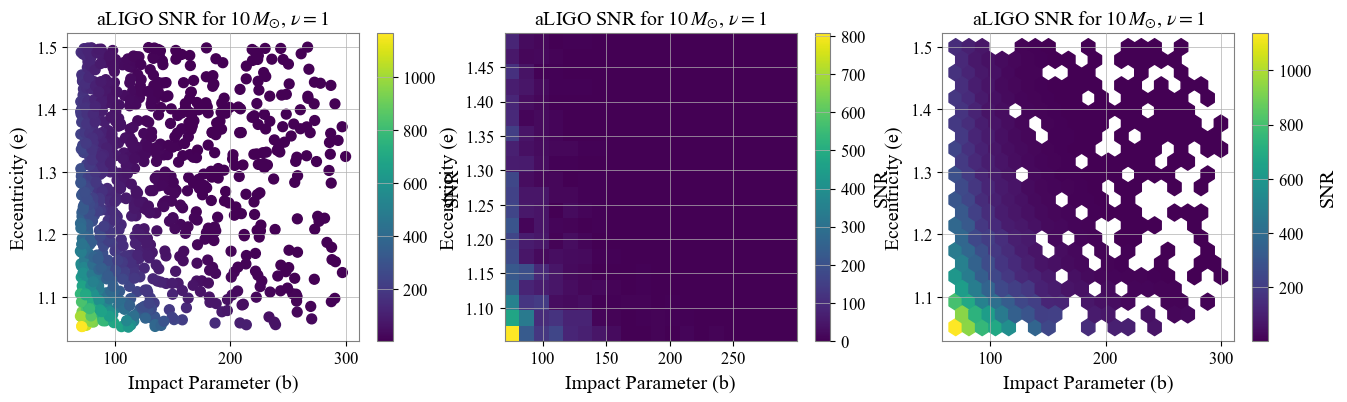

In [108]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
scatter = plt.scatter(valid_b_samples, valid_e_samples, c=snr_values, cmap='viridis', s=50)
plt.colorbar(scatter, label='SNR')
plt.xlabel('Impact Parameter (b)')
plt.ylabel('Eccentricity (e)')
plt.title(r'aLIGO SNR for $10\, M_{\odot}$, $\nu = 1$')

plt.subplot(1, 3, 2)
plt.hist2d(valid_b_samples, valid_e_samples, bins=20, cmap='viridis', weights=snr_values/20)
plt.colorbar(label='SNR')
plt.xlabel('Impact Parameter (b)')
plt.ylabel('Eccentricity (e)')
plt.title(r'aLIGO SNR for $10\, M_{\odot}$, $\nu = 1$')

plt.subplot(1, 3, 3)
hb = plt.hexbin(valid_b_samples, valid_e_samples, gridsize=20, cmap='viridis', C=snr_values, reduce_C_function=np.mean)
plt.colorbar(hb, label='SNR')
plt.xlabel('Impact Parameter (b)')
plt.ylabel('Eccentricity (e)')
plt.title(r'aLIGO SNR for $10\, M_{\odot}$, $\nu = 1$')
plt.savefig('snr_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [260]:
hyp_eccenctricity = [1.15, 1.3]
impact_param = [60, 100]

hyperbolic = []
for ecc in hyp_eccenctricity:
    for b in impact_param:
        hyper = HyperbolicGW(10, 10, ecc, b, 1e7, np.pi/3)
        wav_td = hyper.td_waveform()
        wav_fd = hyper.fd_waveform()
        hyperbolic.append((wav_td, wav_fd))

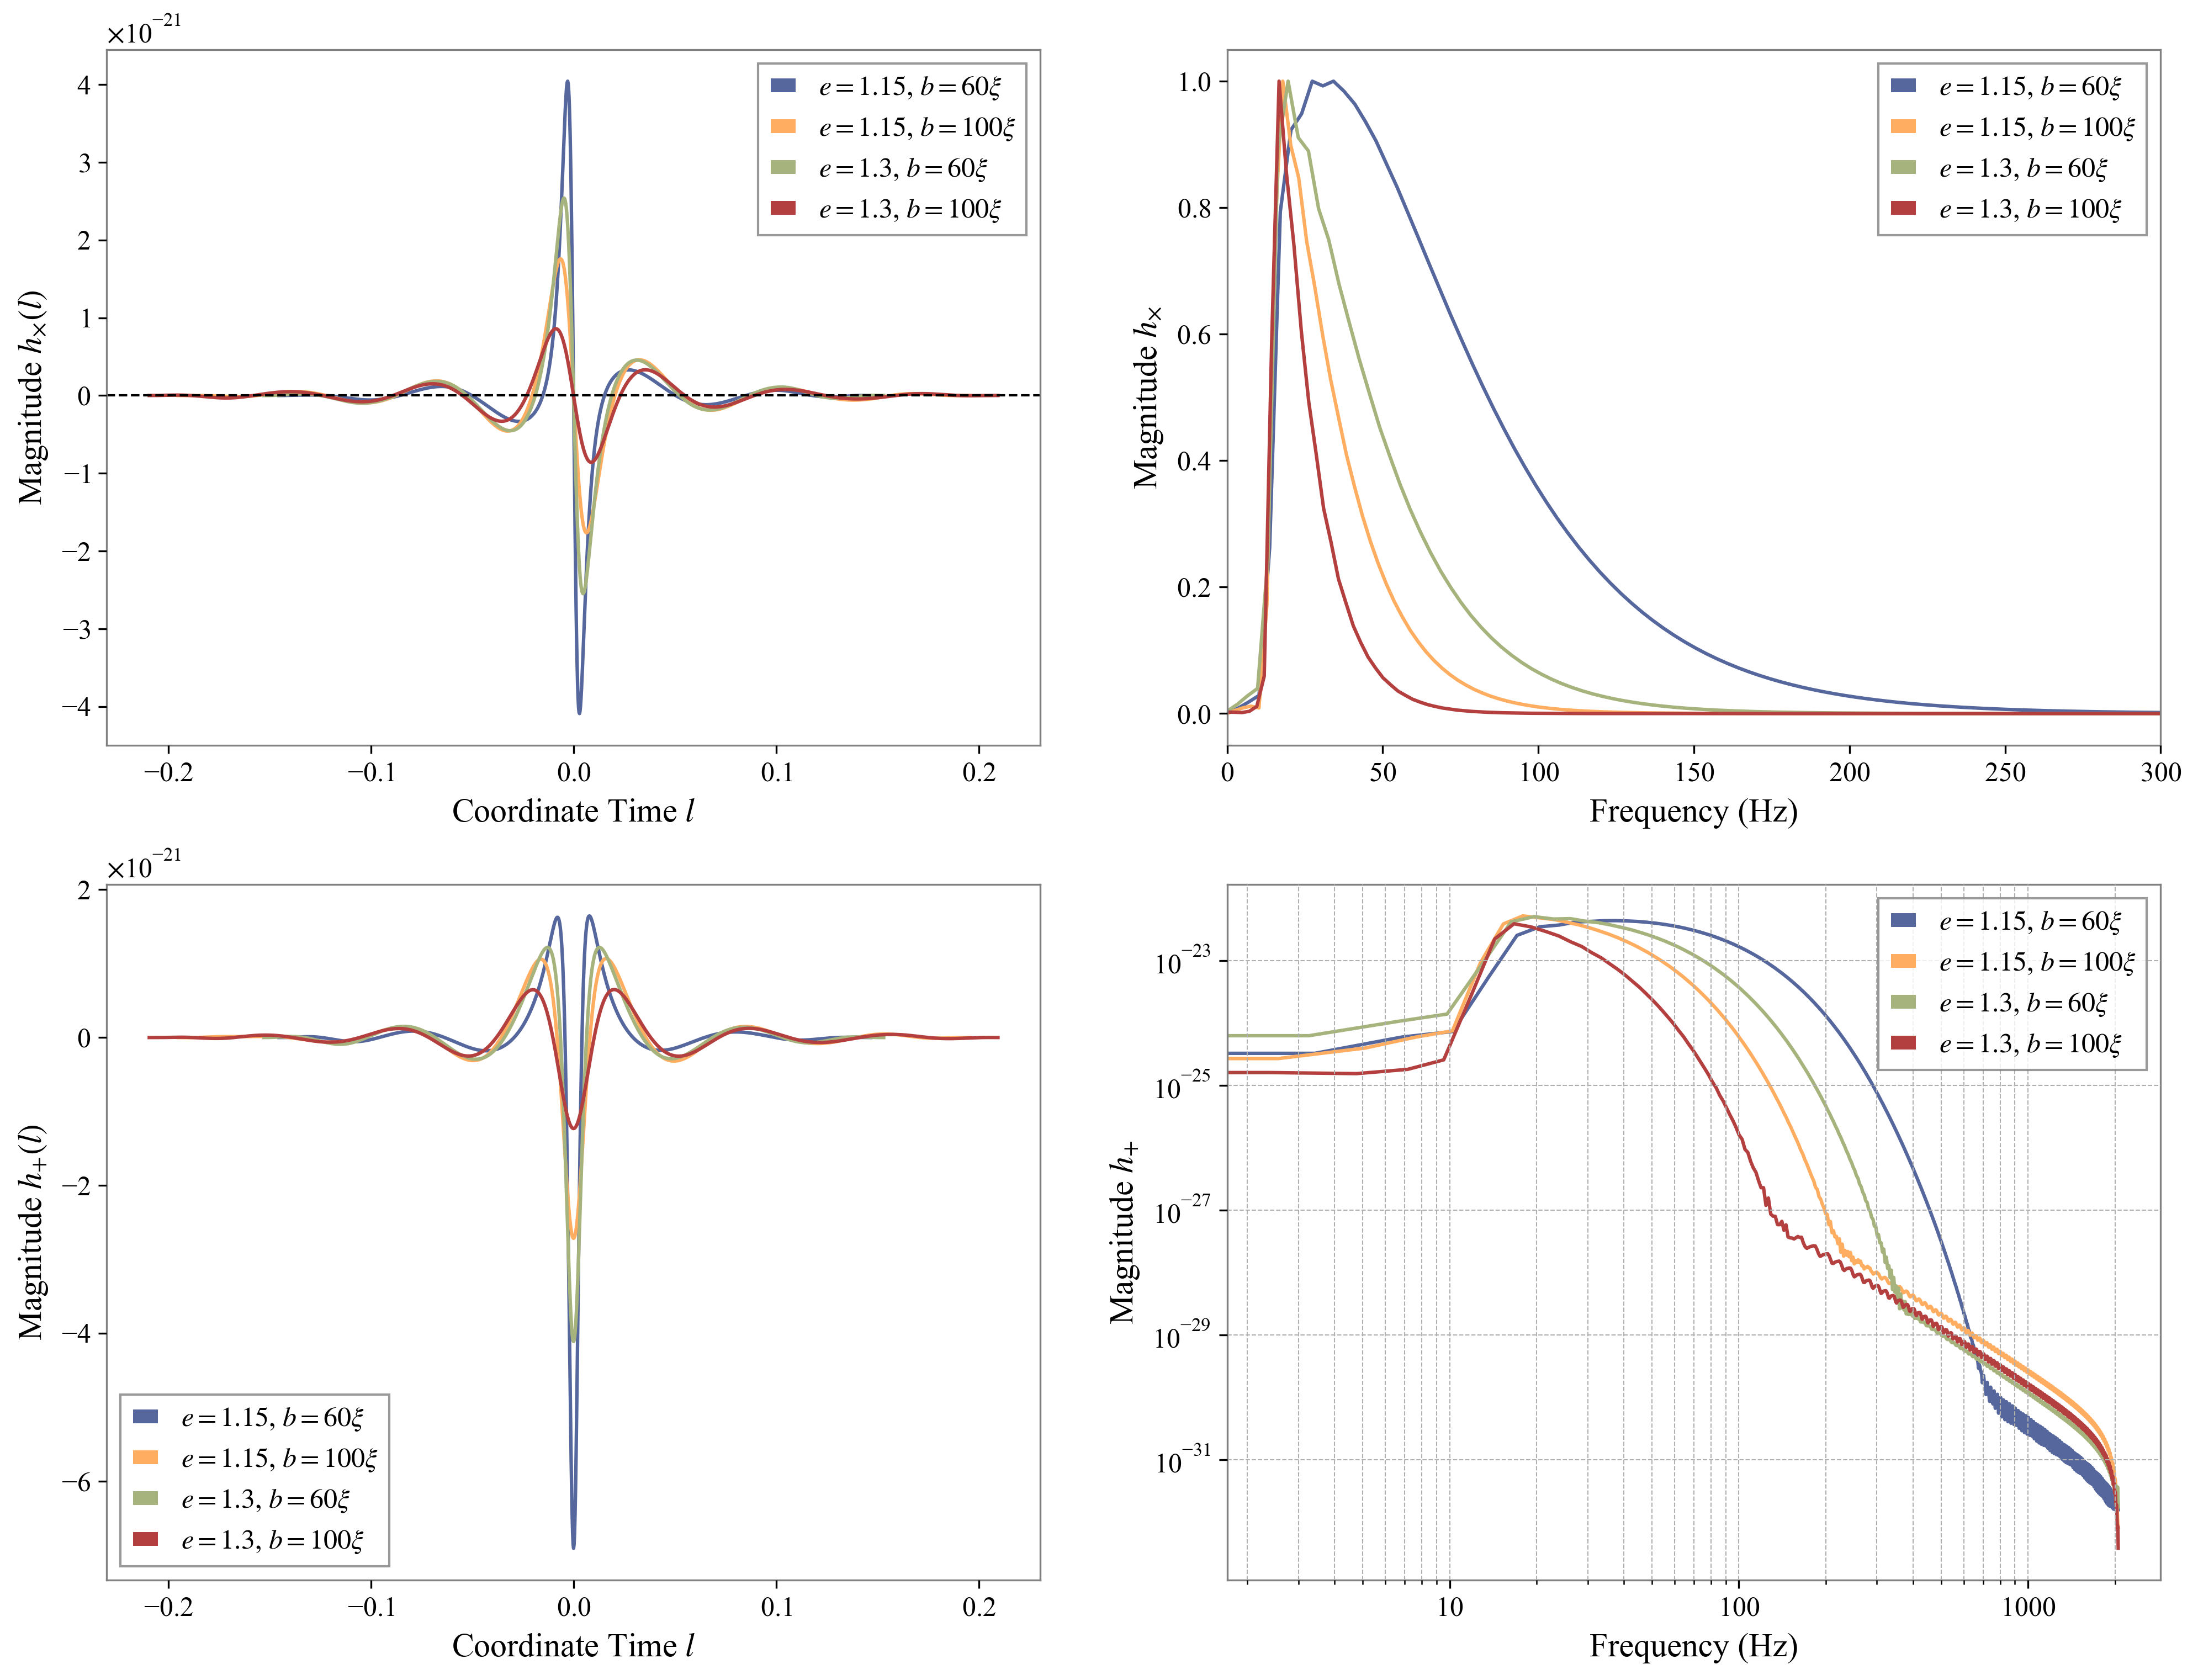

In [262]:
labels = [
        r"$e=1.15$, $b = 60\xi$",
        r"$e=1.15$, $b = 100\xi$",
        r"$e=1.3$, $b = 60\xi$",
        r"$e=1.3$, $b = 100\xi$"
        ]
colors = ["#55679C", "#FFAD60", "#A6B37D", "#B43F3F"]
plt.figure(figsize=(16, 12), dpi = 300)

plt.subplot(2, 2, 1)
for i in range(4):
    plt.plot(hyperbolic[i][0][1].sample_times, hyperbolic[i][0][1], 
             color = colors[i], label=labels[i])
plt.axhline(0, color='black', linestyle='--', linewidth=1.0)
plt.xlabel(r"Coordinate Time $l$")
plt.ylabel(r"Magnitude $h_{\times}(l)$")
plt.grid(False)
plt.legend()

plt.subplot(2, 2, 2)
for i in range(4):
    plt.plot(hyperbolic[i][1][1].sample_frequencies, np.abs(hyperbolic[i][1][1].numpy())/np.max(np.abs(hyperbolic[i][1][1].numpy())), 
         color = colors[i], label=labels[i])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Magnitude $h_{\times}$")
plt.xlim(0, 300)
plt.grid(False)
plt.legend()

plt.subplot(2, 2, 3)
for i in range(4):
    plt.plot(hyperbolic[i][0][0].sample_times, hyperbolic[i][0][0], color = colors[i], label=labels[i])
plt.xlabel(r"Coordinate Time $l$")
plt.ylabel(r"Magnitude $h_{+}(l)$")
plt.legend()
plt.grid(False)

plt.subplot(2, 2, 4)
for i in range(4):
    plt.loglog(hyperbolic[i][1][0].sample_frequencies, abs(hyperbolic[i][1][0]), color = colors[i], label=labels[i])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Magnitude $h_{+}$")
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()